## Henry Problem

Classic saltwater intrusion

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl

import flopy
import git
import matplotlib.pyplot as plt
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Scenario-specific parameters - make sure there is at least one blank line before next item
parameters = {
    "ex-gwt-henry-a": {
        "inflow": 5.7024,
    },
    "ex-gwt-henry-b": {
        "inflow": 2.851,
    },
}

# Scenario parameter units - make sure there is at least one blank line before next item
# add parameter_units to add units to the scenario parameter table
parameter_units = {
    "inflow": "$m^3/d$",
}

# Model units
length_units = "centimeters"
time_units = "seconds"

# Model parameters
nper = 1  # Number of periods
nstp = 500  # Number of time steps
perlen = 0.5  # Simulation time length ($d$)
nlay = 40  # Number of layers
nrow = 1  # Number of rows
ncol = 80  # Number of columns
system_length = 2.0  # Length of system ($m$)
delr = 0.025  # Column width ($m$)
delc = 1.0  # Row width ($m$)
delv = 0.025  # Layer thickness
top = 1.0  # Top of the model ($m$)
hydraulic_conductivity = 864.0  # Hydraulic conductivity ($m d^{-1}$)
initial_concentration = 35.0  # Initial concentration (unitless)
porosity = 0.35  # porosity (unitless)
diffusion_coefficient = 0.57024  # diffusion coefficient ($m^2/d$)

botm = [top - k * delv for k in range(1, nlay + 1)]

nouter, ninner = 100, 300
hclose, rclose, relax = 1e-10, 1e-6, 0.97

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
def build_models(sim_folder, inflow):
    print(f"Building model...{sim_folder}")
    name = "flow"
    sim_ws = os.path.join(workspace, sim_folder)
    sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=sim_ws, exe_name="mf6")
    tdis_ds = ((perlen, nstp, 1.0),)
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
    ims = flopy.mf6.ModflowIms(
        sim,
        print_option="ALL",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="BICGSTAB",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename=f"{gwf.name}.ims",
    )
    sim.register_ims_package(ims, [gwf.name])
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwfnpf(
        gwf,
        save_specific_discharge=True,
        icelltype=0,
        k=hydraulic_conductivity,
    )
    flopy.mf6.ModflowGwfic(gwf, strt=initial_concentration)
    pd = [(0, 0.7, 0.0, "trans", "concentration")]
    flopy.mf6.ModflowGwfbuy(gwf, packagedata=pd)
    ghbcond = hydraulic_conductivity * delv * delc / (0.5 * delr)
    ghbspd = [[(k, 0, ncol - 1), top, ghbcond, 35.0] for k in range(nlay)]
    flopy.mf6.ModflowGwfghb(
        gwf,
        stress_period_data=ghbspd,
        pname="GHB-1",
        auxiliary="CONCENTRATION",
    )

    welspd = [[(k, 0, 0), inflow / nlay, 0.0] for k in range(nlay)]
    flopy.mf6.ModflowGwfwel(
        gwf,
        stress_period_data=welspd,
        pname="WEL-1",
        auxiliary="CONCENTRATION",
    )
    head_filerecord = f"{name}.hds"
    budget_filerecord = f"{name}.bud"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )

    gwt = flopy.mf6.ModflowGwt(sim, modelname="trans")
    imsgwt = flopy.mf6.ModflowIms(
        sim,
        print_option="ALL",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="BICGSTAB",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename=f"{gwt.name}.ims",
    )
    sim.register_ims_package(imsgwt, [gwt.name])
    flopy.mf6.ModflowGwtdis(
        gwt,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwtmst(gwt, porosity=porosity)
    flopy.mf6.ModflowGwtic(gwt, strt=initial_concentration)
    flopy.mf6.ModflowGwtadv(gwt, scheme="UPSTREAM")
    flopy.mf6.ModflowGwtdsp(gwt, xt3d_off=True, diffc=diffusion_coefficient)
    sourcerecarray = [
        ("GHB-1", "AUX", "CONCENTRATION"),
        ("WEL-1", "AUX", "CONCENTRATION"),
    ]
    flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray)
    flopy.mf6.ModflowGwtoc(
        gwt,
        budget_filerecord=f"{gwt.name}.cbc",
        concentration_filerecord=f"{gwt.name}.ucn",
        concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[("CONCENTRATION", "ALL")],
        printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
    )
    flopy.mf6.ModflowGwfgwt(
        sim, exgtype="GWF6-GWT6", exgmnamea=gwf.name, exgmnameb=gwt.name
    )
    return sim


def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)


@timed
def run_models(sim, silent=True):
    success, buff = sim.run_simulation(silent=silent)
    assert success, buff

### Plotting results

Define functions to plot model results.

In [4]:
# Figure properties
figure_size = (6, 4)


def plot_conc(sim, idx):
    with styles.USGSMap():
        sim_name = list(parameters.keys())[idx]
        gwf = sim.get_model("flow")
        gwt = sim.get_model("trans")

        fig = plt.figure(figsize=figure_size)
        fig.tight_layout()

        # get MODFLOW 6 concentration
        conc = gwt.output.concentration().get_data()

        ax = fig.add_subplot(1, 1, 1, aspect="equal")
        pxs = flopy.plot.PlotCrossSection(model=gwf, ax=ax, line={"row": 0})
        pxs.plot_array(conc, cmap="jet")
        levels = [35 * f for f in [0.01, 0.1, 0.5, 0.9, 0.99]]
        cs = pxs.contour_array(
            conc, levels=levels, colors="w", linewidths=1.0, linestyles="-"
        )
        ax.set_xlabel("x position (m)")
        ax.set_ylabel("z position (m)")
        plt.clabel(cs, fmt="%4.2f", fontsize=5)

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-conc.png"
            fig.savefig(fpth)


def plot_results(sim, idx):
    plot_conc(sim, idx)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

Building model...ex-gwt-henry-a


run_models took 11951.51 ms


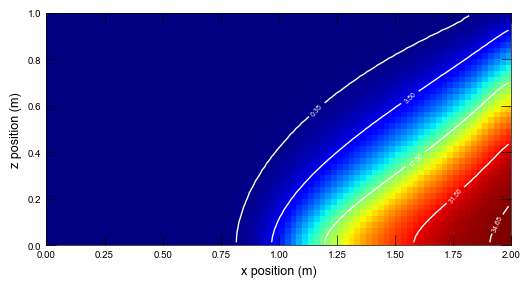

Building model...ex-gwt-henry-b


run_models took 11934.87 ms


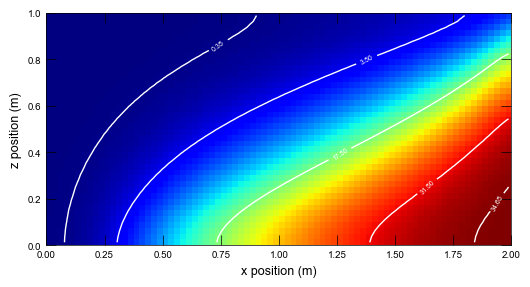

In [5]:
def scenario(idx, silent=True):
    key = list(parameters.keys())[idx]
    parameter_dict = parameters[key]
    sim = build_models(key, **parameter_dict)
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)
    if plot:
        plot_results(sim, idx)


# Scenario 1 - Classic henry problem
scenario(0)

# Scenario 2 - Modified Henry problem with half the inflow rate
scenario(1)